In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Union, Callable
from tqdm import tqdm

from lattice import SquareLattice, BrickwallLattice
import qutip as qu

In [8]:
def get_lindblad_operators(L, gamma: float) -> List[qu.Qobj]:
    jump_ops = []
    N = L**2

    # Top boundary: inject particles
    for i in range(L):  # Loop over left edge sites
        L_i = np.zeros((N, N), dtype=complex)
        L_i[i, i] = 1.0
        jump_ops.append(qu.Qobj(np.sqrt(gamma) * L_i) * qu.create(N))  # Injection
    
    # Bottom boundary: remove particles
        L_i[i, i] = 0
        L_i[i + L*(L-1), i + L*(L - 1)] = 1.0
        jump_ops.append(qu.Qobj(np.sqrt(gamma) * L_i) * qu.destroy(N))  # Removal
    
    return jump_ops



sq = SquareLattice(L=6, t_hop=1j, E_amplitude=0.1, E_dir=np.array([1, 0]), h=0.1, steps=1000, initial_occupation=0.5)
sq.evolve(c_ops = get_lindblad_operators(sq.L, 0.1), progress_bar=True)

Creating Hamiltonians...
Done.
Calculating energy eigenstates...
Done.
50 % of states were set as initially occupied.


/home/prl52162/Schreibtisch/orbitronics_research_project/prl_orbital_current_sim/lib/python3.11/site-packages/qutip/solver/solver_base.py:479: FutureWarning: "progress_bar" is now included in options:
 Use `options={"progress_bar": False / True / "tqdm" / "enhanced"}`
  warnings.warn(


10.0%. Run time:   2.19s. Est. time left: 00:00:00:19
20.0%. Run time:   3.80s. Est. time left: 00:00:00:15
30.0%. Run time:   5.77s. Est. time left: 00:00:00:13
40.0%. Run time:   7.93s. Est. time left: 00:00:00:11
50.1%. Run time:   9.68s. Est. time left: 00:00:00:09
60.1%. Run time:  13.81s. Est. time left: 00:00:00:09
70.1%. Run time:  17.03s. Est. time left: 00:00:00:07
80.1%. Run time:  18.39s. Est. time left: 00:00:00:04
90.1%. Run time:  20.58s. Est. time left: 00:00:00:02
100.0%. Run time:  22.83s. Est. time left: 00:00:00:00
Total run time:  22.83s


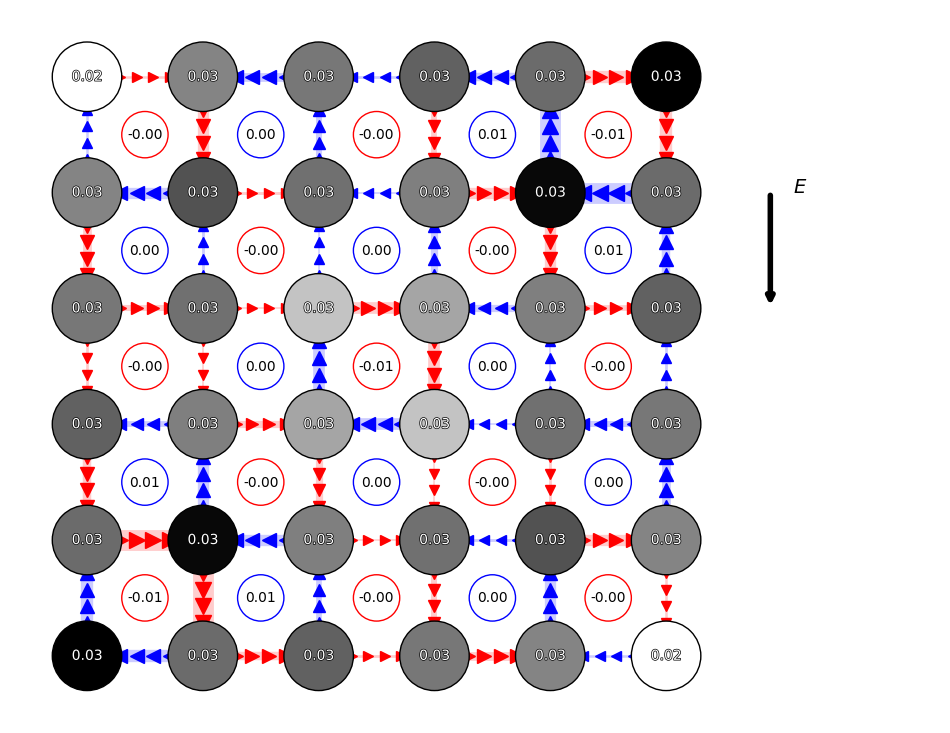

In [9]:
sq.animate_current_density("test_lindblad.gif", dpi=70, bitrate=1600, sample_every=8)

In [ ]:
bw = BrickwallLattice(L=6, t_hop=1, E_amplitude=.01, E_dir=np.array([1, 0]), h=2e-4, steps=20_000, initial_occupation=0.5)
bw.evolve()
bw.animate_current_density("test curl bw.gif", sample_every=287, fps=10, dpi=75, bitrate=1500)

In [ ]:
sq = SquareLattice(L=6, t_hop=1j, E_amplitude=0.01, E_dir=np.array([1, 0]), h=0.1, steps=100, initial_occupation=0.5)
sq.evolve()
sq.animate_current_density("test_curl.gif", fps=10, sample_every=2, dpi=75, bitrate=1500)

In [3]:
def test_convergence(T:float, hspace:np.ndarray, lattice: SquareLattice):
    densities = []
    for h in tqdm(hspace):
        lattice.h = h
        lattice.steps = int(T/h)
        lattice.evolve(force_reevolve=True)
        densities.append(np.diag(lattice.get_state(-1)).real)

    return densities

In [20]:
sq = SquareLattice(L=4, t_hop=1, E_amplitude=lambda t: np.cos(t)*0.01, E_dir=np.array([1, 0]), initial_occupation=0.5, h=None, steps=None)

hspace = np.logspace(-5, 0, 30, base=10)
densities = np.array(test_convergence(5, hspace, sq))

Creating Hamiltonians...
Done.
Calculating energy eigenstates...
Done.
50 % of states were set as initially occupied.


100%|██████████| 30/30 [00:32<00:00,  1.09s/it]


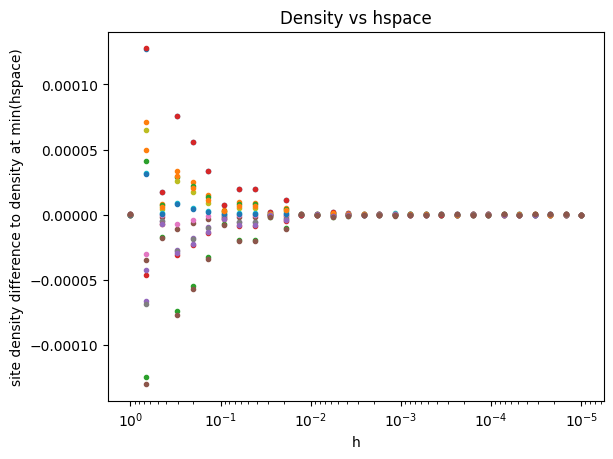

In [21]:
plt.gca().invert_xaxis()
plt.xscale('log')
#plt.yscale('log')

plt.xlabel('h')
plt.ylabel('site density difference to density at min(hspace)')
plt.title('Density vs hspace')

for site in range(sq.L**2):
    plt.plot(hspace, densities[:, site] - densities[:, site][0] , ".")
plt.show()